In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os 
os.chdir('/content/drive/MyDrive/ML_Challenge_Seg/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!pip install -q segmentation-models-pytorch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time 
from tqdm.notebook import tqdm
from torchsummary import summary
import segmentation_models_pytorch as smp
import warnings
warnings.filterwarnings("ignore")

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

!pip install -U albumentations

In [5]:
import cv2
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
from albumentations.augmentations.crops.transforms import CropNonEmptyMaskIfExists, RandomCrop
import random
import os 
from scipy.ndimage import rotate

import albumentations as A

IMAGES_TO_GENERATE = 2000

images_path = 'image_chips/'
mask_path = 'target_data/'

img_aug_path = 'AUG_DATA_FINAL/train'
mask_aug_path = 'AUG_DATA_FINAL/masks'

images= sorted(glob.glob(images_path + '/*.jpg'))
masks = sorted(glob.glob(mask_path + '/*.jpg'))

aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    A.GridDistortion(p=1),
    CropNonEmptyMaskIfExists(p=0.3,height=512,width=512),
    A.geometric.rotate.Rotate (limit=90, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
])


'''for i in tqdm(range(IMAGES_TO_GENERATE), desc = 'Augmenting Data'):
    number= random.randint(0,len(images)-1)
    image = images[number]
    mask = masks[number]
    original_image =io.imread(image)
    original_mask =io.imread(mask)    
    augmented = aug(image=original_image,mask=original_mask)
    transformed_image = augmented['image']
    transformed_mask = augmented['mask']   
    new_image_path ='%s/%s.png'%(img_aug_path,i) 
    new_mask_path ='%s/%s.png'%(mask_aug_path,i) 
    io.imsave(new_image_path,transformed_image)
    io.imsave(new_mask_path,transformed_mask)'''

"for i in tqdm(range(IMAGES_TO_GENERATE), desc = 'Augmenting Data'):\n    number= random.randint(0,len(images)-1)\n    image = images[number]\n    mask = masks[number]\n    original_image =io.imread(image)\n    original_mask =io.imread(mask)    \n    augmented = aug(image=original_image,mask=original_mask)\n    transformed_image = augmented['image']\n    transformed_mask = augmented['mask']   \n    new_image_path ='%s/%s.png'%(img_aug_path,i) \n    new_mask_path ='%s/%s.png'%(mask_aug_path,i) \n    io.imsave(new_image_path,transformed_image)\n    io.imsave(new_mask_path,transformed_mask)"

In [6]:
images = 'AUG_DATA_FINAL/train/'
targets = 'AUG_DATA_FINAL/masks/'

n_classes = 2

def _df_():
  name = []
  for dirname ,_ , filenames in os.walk(images):
    for filename in filenames:
      name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id':name} , index = np.arange(0, len(name)))

df = _df_()
print(len(df))

2000


In [7]:
X_train , X_val = train_test_split(df['id'].values , test_size
                                   =0.2, random_state =19)
print(f'Train : {len(X_train)}')
print(f'Val : {len(X_val)}')

Train : 1600
Val : 400


Image Size (750, 750, 3)
Mask Size (750, 750)


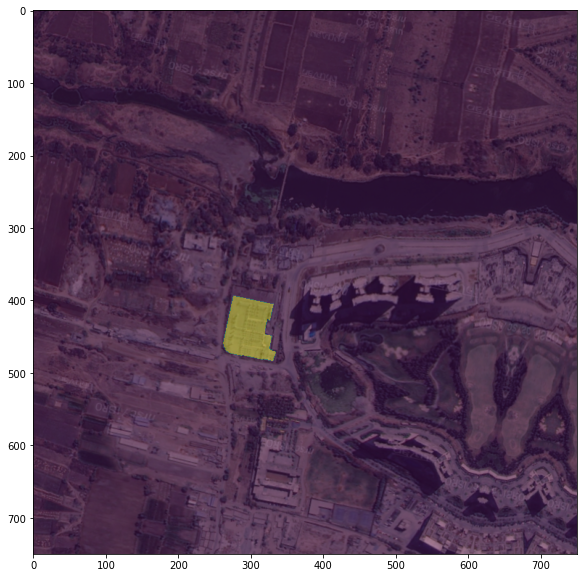

In [8]:
img = Image.open(images + df['id'][100] + '.png')
targ = Image.open(targets + df['id'][100] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size' , np.asarray(targ).shape)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(targ , alpha =0.4)
plt.show()

In [9]:
def dense_target(tar: np.ndarray):
    classes =np.unique(tar)
    dummy= np.zeros_like(tar)
    for idx , value in enumerate(classes):
        mask = np.where(tar == value)
        dummy[mask] = idx
    return dummy

class SegData(Dataset):

  def __init__(self , image_path , target_path , X , mean , std , transform =None , test=False):
    self.image_path = image_path
    self.target_path = target_path
    self.X = X
    self.transform =transform
    self.mean = mean
    self.std = std
    self.test =test

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    img = cv2.cvtColor(cv2.imread(self.image_path + self.X[idx] + '.png') , cv2.COLOR_BGR2RGB)
    target = cv2.imread(self.target_path + self.X[idx] + '.png' , cv2.IMREAD_GRAYSCALE)
    kernel_sharp = np.array(([-2, -2, -2], [-2, 17, -2], [-2, -2, -2]), dtype='int')
    img = cv2.filter2D(img, -1, kernel_sharp)
    target = cv2.filter2D(target, -1, kernel_sharp)
    img = cv2.resize(img, (512, 512) , interpolation = cv2.INTER_NEAREST)
    target = cv2.resize(target , (512 , 512), interpolation = cv2.INTER_NEAREST)
    target = np.where( target > 0,255,0)
  
    if self.transform is not None:
      aug = self.transform(image = img , target = target )
      img = Image.fromarray(aug['image'])
      target = aug['target']
    
    if self.transform is None:
      img = Image.fromarray(img) 
    
    t = T.Compose([T.ToTensor() , T.Normalize(self.mean , self.std)])
    
    if self.test is False:
      img = t(img)
    target = dense_target(target)
    target = torch.from_numpy(target).long()
    return img ,target

In [10]:
mean = [0.485 ,0.456 ,0.406]
std = [0.229 , 0.224 , 0.225]

train_set = SegData(images, targets, X_train , mean, std)
val_set = SegData(images , targets , X_val , mean , std)

batch_size =4
train_loader= DataLoader(train_set , batch_size= batch_size , shuffle =True)
val_loader = DataLoader(val_set , batch_size = batch_size , shuffle =True)

In [11]:
x , y =next(iter(train_loader))

print(f' x = shape : {x.shape} ; type :{x.dtype}')
print(f' x = min : {x.min()} ; max : {x.max()}')
print(f' y = shape: {y.shape}; class : {y.unique()}; type: {y.dtype}')

 x = shape : torch.Size([4, 3, 512, 512]) ; type :torch.float32
 x = min : -2.1179039478302 ; max : 2.640000104904175
 y = shape: torch.Size([4, 512, 512]); class : tensor([0, 1]); type: torch.int64


In [12]:
model = smp.DeepLabV3Plus('efficientnet-b3',encoder_weights='imagenet', classes = 2, encoder_output_stride =16, activation=None,
                 encoder_depth= 5)
model=model.to(device)

In [13]:
model

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )

In [14]:
def pixel_wise_accuracy(output , mask):
  with torch.no_grad():
    output = torch.argmax(F.softmax(output , dim =1) , dim=1)
    correct = torch.eq(output , mask).int()
    accuracy = float(correct.sum())/ float(correct.numel())#total number
  return accuracy

In [15]:
def IoU(pred , true_pred , smooth =1e-10 , n_classes=2):
  with torch.no_grad():
    pred = torch.argmax(F.softmax(pred , dim =1) , dim=1)
    pred = pred.contiguous().view(-1)
    true_pred = true_pred.contiguous().view(-1)

    iou_class = []
    for value in range(0, n_classes):
      true_class = pred == value
      true_label = true_pred == value

      if true_label.long().sum().item()==0:
        iou_class.append(np.nan)
        
      else:
    
        inter = torch.logical_and(true_class, true_label).sum().float().item()
        union = torch.logical_or(true_class , true_label).sum().float().item()

        iou = (inter + smooth)/(union + smooth)
        iou_class.append(iou)

    return np.nanmean(iou_class)

In [16]:
def DiceBceLoss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = 1- ((2.*intersection + eps)/(cardinality + eps)).mean()
    bce = F.cross_entropy(logits, true , reduction ="mean")
    dice_bce = bce + dice_loss
    return dice_bce

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, optimizer, scheduler, patch=False):
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = DiceBceLoss(mask, output)
            #evaluation metrics
            iou_score += IoU(output, mask)
            accuracy += pixel_wise_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  IoU(output, mask)
                    test_accuracy += pixel_wise_accuracy(output, mask)
                    #loss
                    loss = DiceBceLoss(mask, output)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'model-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            # if (test_loss/len(val_loader)) > min_loss:
            #     not_improve += 1
            #     min_loss = (test_loss/len(val_loader))
            #     print(f'Loss did not  Decrease for {not_improve} time')
            #     if not_improve == 7:
            #         print('Loss did not decrease for the 7th time , Stop Training')
            #         break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train IoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val IoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [18]:
max_lr = 1e-3
epoch = 50
weight_decay = 1e-6

optimizer = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, optimizer, sched)


Loss Decreasing.. inf >> 0.363 
Epoch:1/50.. Train Loss: 0.557.. Val Loss: 0.363.. Train IoU:0.743.. Val IoU: 0.847.. Train Acc:0.945.. Val Acc:0.970.. Time: 3.15m



Loss Decreasing.. 0.363 >> 0.305 
Epoch:2/50.. Train Loss: 0.345.. Val Loss: 0.305.. Train IoU:0.837.. Val IoU: 0.870.. Train Acc:0.968.. Val Acc:0.975.. Time: 3.16m



Loss Decreasing.. 0.305 >> 0.264 
Epoch:3/50.. Train Loss: 0.285.. Val Loss: 0.264.. Train IoU:0.875.. Val IoU: 0.895.. Train Acc:0.977.. Val Acc:0.981.. Time: 3.19m



Loss Decreasing.. 0.264 >> 0.246 
saving model...
Epoch:4/50.. Train Loss: 0.253.. Val Loss: 0.246.. Train IoU:0.896.. Val IoU: 0.901.. Train Acc:0.981.. Val Acc:0.981.. Time: 3.18m



Loss Decreasing.. 0.246 >> 0.246 
Epoch:5/50.. Train Loss: 0.233.. Val Loss: 0.246.. Train IoU:0.909.. Val IoU: 0.906.. Train Acc:0.984.. Val Acc:0.982.. Time: 3.19m



Loss Decreasing.. 0.246 >> 0.227 
Epoch:6/50.. Train Loss: 0.253.. Val Loss: 0.227.. Train IoU:0.902.. Val IoU: 0.914.. Train Acc:0.981.. Val Acc:0.985.. Time: 3.20m



Epoch:7/50.. Train Loss: 0.222.. Val Loss: 0.241.. Train IoU:0.917.. Val IoU: 0.913.. Train Acc:0.985.. Val Acc:0.985.. Time: 3.23m



Loss Decreasing.. 0.227 >> 0.226 
Epoch:8/50.. Train Loss: 0.237.. Val Loss: 0.226.. Train IoU:0.908.. Val IoU: 0.920.. Train Acc:0.983.. Val Acc:0.986.. Time: 3.22m



Epoch:9/50.. Train Loss: 0.236.. Val Loss: 0.496.. Train IoU:0.912.. Val IoU: 0.735.. Train Acc:0.984.. Val Acc:0.931.. Time: 3.24m



Epoch:10/50.. Train Loss: 0.248.. Val Loss: 0.257.. Train IoU:0.902.. Val IoU: 0.898.. Train Acc:0.982.. Val Acc:0.980.. Time: 3.21m



Epoch:11/50.. Train Loss: 0.215.. Val Loss: 0.230.. Train IoU:0.924.. Val IoU: 0.915.. Train Acc:0.987.. Val Acc:0.985.. Time: 3.22m



Loss Decreasing.. 0.226 >> 0.214 
Epoch:12/50.. Train Loss: 0.202.. Val Loss: 0.214.. Train IoU:0.936.. Val IoU: 0.928.. Train Acc:0.989.. Val Acc:0.987.. Time: 3.19m



Epoch:13/50.. Train Loss: 0.258.. Val Loss: 0.270.. Train IoU:0.896.. Val IoU: 0.883.. Train Acc:0.980.. Val Acc:0.978.. Time: 3.16m



Epoch:14/50.. Train Loss: 0.235.. Val Loss: 0.230.. Train IoU:0.909.. Val IoU: 0.918.. Train Acc:0.984.. Val Acc:0.985.. Time: 3.19m



Loss Decreasing.. 0.214 >> 0.211 
saving model...
Epoch:15/50.. Train Loss: 0.209.. Val Loss: 0.211.. Train IoU:0.929.. Val IoU: 0.930.. Train Acc:0.988.. Val Acc:0.988.. Time: 3.17m


KeyboardInterrupt: ignored

In [ ]:
test_set = SegData(images, targets, X_val ,mean , std, transform = None , test = True)

In [ ]:
def predict_image_mask(model, image , mask , mean=[0.485, 0.456, 0.406],
                       std = [0.229 , 0.224 ,0.225]):
  model.eval()
  t= T.Compose([T.ToTensor() ,T.Normalize(mean, std)])
  image = t(image)
  model.to(device) ; image = image.to(device)
  mask = mask.to(device)
  with torch.no_grad():

    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

    output = model(image)
    score = IoU(output, mask)
    masked = torch.argmax(output , dim =1)
    masked = masked.cpu().squeeze(0)
  return masked , score

In [ ]:
import random
for i in range(10,20):
  image , mask = test_set[i]
  pred_mask , score = predict_image_mask(model , image , mask)
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(pred_mask)
  ax3.set_title('UNet-Resnet50 | IoU {:.3f}'.format(score))
  ax3.set_axis_off()

In [ ]:
def predict_final_mask(model, image , mean=[0.485, 0.456, 0.406],
                       std = [0.229 , 0.224 ,0.225]):
  model.eval()
  t= T.Compose([T.ToTensor() ,T.Normalize(mean, std)])
  image = t(image)
  model.to(device) ; image = image.to(device)
  with torch.no_grad():

    image = image.unsqueeze(0)

    output = model(image)
    masked = torch.argmax(output , dim =1)
    masked = masked.cpu().squeeze(0)
  return masked

In [ ]:
im = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/ML_Challenge_Seg/AUG_DATA_FINAL/train/20.png') , cv2.COLOR_BGR2RGB)
kernel_sharp = np.array(([-2, -2, -2], [-2, 17, -2], [-2, -2, -2]), dtype='int')
im = cv2.filter2D(img, -1, kernel_sharp)
im = cv2.resize(im, (512 , 512) , interpolation = cv2.INTER_NEAREST)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
pred_mask = predict_final_mask(model , im)
ax1.imshow(im)
ax1.set_title('Picture');

ax2.imshow(pred_mask)
ax2.set_title('UNet-Resnet50'.format(score))
ax2.set_axis_off()